In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
import imageio
import time
from IPython import display
import PIL

import tensorflow as tf
import tensorflow_probability as tfp

C:\Users\vivek\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
# Download MNIST digit images

(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 37s 3us/step


In [3]:
def image_format(images):
    images = images.reshape((images.shape[0], 28, 28, 1))/255
    return np.where(images > 0.5, 1.0, 0.0).astype('float32')

train_images = image_format(train_images)
test_images = image_format(test_images)

In [4]:
train_size = 60000
batch_size = 32
test_size = 10000

In [5]:
train_data = (tf.data.Dataset.from_tensor_slices(train_images))
train_data = train_data.shuffle(train_size).batch(batch_size)

test_data = (tf.data.Dataset.from_tensor_slices(test_images))
test_data = test_data.shuffle(test_size).batch(batch_size)

In [10]:
class VAE(tf.keras.Model):
    def __init__(self, latent_size):
        super(VAE, self).__init__()
        self.latent_size = latent_size
        self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)), # input image size
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_size + latent_size)
        ])
        
        self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_size,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same')
        ])
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_size))
        return self.decode(eps, sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparam(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps*tf.exp(logvar/2.) + mean
    
    def decode(self, z, sigmoid=False):
        logits = self.decoder(z)
        if sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [20]:
def log_normal(sample, mean, logvar, raxis=1):
    return tf.reduce_sum(-0.5*((sample - mean)**2 * tf.exp(-logvar) + logvar + tf.math.log(2. * np.pi)), axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparam(mean, logvar)
    x_logit = model.decode(z)
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logqz_x = log_normal(z, mean, logvar)
    logpz = log_normal(z, 0., 0.)
    
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(model, x, optimizer):
    "Perform one step of optimization"
    
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [21]:
epochs = 10
latent_size = 2
num_examples = 16

random_vector_for_generation = tf.random.normal(shape=[num_examples, latent_size])
model = VAE(latent_size)

In [22]:
def gen_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparam(mean, logvar)
    predictions = model.sample(z)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
        
    plt.savefig(f"image_{epoch}")
    plt.show()

In [23]:
assert batch_size >= num_examples

for test_batch in test_data.take(1):
    test_sample = test_batch[0:num_examples, :, :, :]

Epoch: 1, Test Set ELBO: -177.9746856689453, Time Elapsed: 58.85358715057373


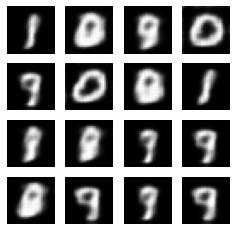

In [ ]:
gen_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    
    for train_x in train_data:
        train_step(model, train_x, optimizer)
        
    end_time = time.time()
    
    loss = tf.keras.metrics.Mean()
    for test_x in test_data:
        loss(compute_loss(model, test_x))
    
    elbo = -loss.result()
    
    display.clear_output(wait=False)
    print(f"Epoch: {epoch}, Test Set ELBO: {elbo}, Time Elapsed: {end_time - start_time}")
    
    gen_save_images(model, epoch, test_sample)